In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

## Converting state_2d for greater presidence in the centre

[-0.85860977 -0.56078504 -0.45210392 -0.37743994 -0.31805508 -0.26736385
 -0.22221444 -0.1808208  -0.14204934 -0.10511488 -0.06943108 -0.03452778
  0.          0.03452778  0.06943108  0.10511488  0.14204934  0.1808208
  0.22221444  0.26736385  0.31805508  0.37743994  0.45210392  0.56078504
  0.85860977]
25


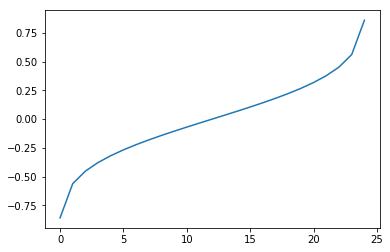

In [2]:
scaling = 1/3 # 1/3 gives a flat distribution when the imput is assumed gaussian, lowering it gives more weight to values -> 0
mcts_bins = 25
discount = 0.7
bin_edges = np.asarray([norm.ppf(edge, scale=scaling) for edge in np.linspace(0.005, 0.995, num=mcts_bins)])
plt.plot(bin_edges)
print(bin_edges)
print(len(bin_edges))

In [3]:
def get_state_2d(self, prev_state_2d=None):
    """
    curr_state numpy array [x_pos, x_vel, angle, ang_vel]
    even though it says state[3] = tip_vel in the docs, its actually ang_vel (since length = 1)
    max values are:        [+-2.4, inf, +-12 = +-0.21rad, inf]
    """
    norm_obs = self.get_rounded_observation()
    edges = np.linspace(-0.5, self.state_bins + 0.5, self.state_bins + 2)
    new_pos, _, _ = np.histogram2d([norm_obs[2], ], [norm_obs[0], ], bins=(edges, edges))

    if prev_state_2d is None:
        # get the values to be roughly within +-1
        prev_obs = (self.state[2] - self.state[3], self.state[0] - self.state[1])
        prev_obs = (prev_obs[0] / self.theta_threshold_radians, prev_obs[1] / self.x_threshold)

        prev_obs_binned = [np.abs(self.bin_edges - elm).argmin() for elm in
                           prev_obs]  # should return the indexes of the norm.cdf
        prev_pos, _, _ = np.histogram2d([prev_obs_binned[0], ], [prev_obs_binned[1], ],
                                        bins=(edges, edges))
        # prev_pos[prev_pos < 1 / (2 ** 5)] = 0   # only keep up to 4 times steps back
        return new_pos + self.discount * prev_pos
    else:
        # prev_state_2d[prev_state_2d < 1 / (2 ** 5)] = 0
        return new_pos + self.discount * prev_state_2d

## Speed of Converting/Binning MCTS States

[-1.03007744 -0.57382132 -0.45919297 -0.38223787 -0.32158558 -0.27006197
 -0.22430572 -0.18243623 -0.14327024 -0.10599338 -0.07000043 -0.03480781
  0.          0.03480781  0.07000043  0.10599338  0.14327024  0.18243623
  0.22430572  0.27006197  0.32158558  0.38223787  0.45919297  0.57382132
  1.03007744]


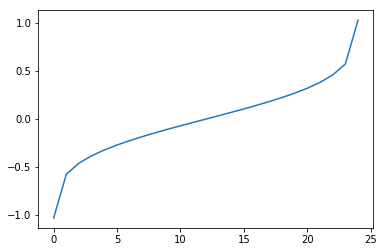

In [4]:
scaling = 1/3 # 1/3 gives a flat distribution when the imput is assumed gaussian, lowering it gives more weight to values -> 0
mcts_bins = 25
bin_edges = np.asarray([norm.ppf(edge, scale=scaling) for edge in np.linspace(0.001, 0.999, num=mcts_bins)])
plt.plot(bin_edges)
print(bin_edges)

In [5]:
def get_rounded_observation1(state):
    """ norm.cfd not implemented """
    # would divide by self.threshold here
    obs = [state[0],
           state[1],
           state[2],
           state[3]
           ]

    obs = [int(round(elm*mcts_bins)) for elm in obs]
    return tuple(obs)

def get_rounded_observation2(state):
    """ Possible better implementation of norm.cdf """
    # would divide by self.threshold here
    obs = [state[0],
           state[1],
           state[2],
           state[3]
           ]
    # what about calculating a list of bin edges at the start using inverse cfd (norm.ppf),
    # and then running each thing through until we get to said list idx then returning the index as the
    # norm cdf'd output? would remove the whole astype(int) things too so maybe even faster if small enough?
    
    obs = [np.abs(bin_edges-elm).argmin() for elm in obs]    # should return the indexes of the norm.cdf
    return tuple(obs)
    
    

def get_rounded_observation3(state):
    """ naive implementation of norm.cdf """
    obs = [state[0],
           state[1],
           state[2],
           state[3],
           ]
    obs = norm.cdf(obs, scale=scaling)
    obs = np.round(obs*mcts_bins).astype(int)
    return tuple(obs.tolist())

In [6]:
norm_values, unif_values = [], []
nv, uv = [], []
for i in range(20000):
    n = np.random.randn(4)/3
    norm_values.append(n)
    nv.extend(n)
    
    u = (np.random.rand(4)-0.5)*2
    unif_values.append(u)
    uv.extend(u)

In [7]:
def repeat(values, func):
    comp = []
    for v in values:
        obs = func(v)
        comp.extend(obs)
    return comp

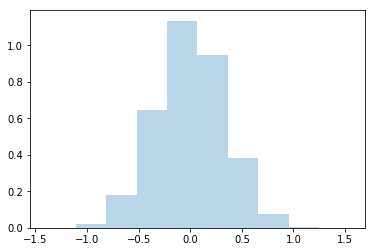

In [14]:
plt.hist(nv, alpha=0.3, density=True)
# plt.plot(bin_edges)
# plt.hist(uv, alpha=0.3)
plt.show()

In [9]:
%time naive = repeat(norm_values, get_rounded_observation1)
%time test = repeat(norm_values, get_rounded_observation2)
%time working = repeat(norm_values, get_rounded_observation3)

Wall time: 177 ms
Wall time: 199 ms
Wall time: 1.57 s


In [10]:
print(max(test), min(test))

24 0


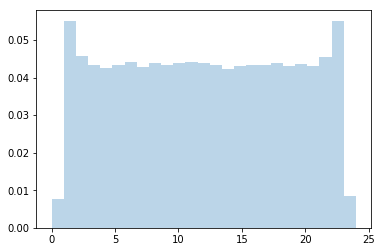

In [15]:
plt.hist(test, alpha=0.3, bins=25, density=True)
# plt.hist(working, alpha=0.3, bins=25)
# plt.hist(naive, alpha=0.3, bins=25)

# also plot how a uniform dist would look:
# plt.hist(repeat(unif_values, get_rounded_observation2), alpha=0.3, bins=25)
# plt.ylim([0, 10000])
plt.show()

## joining paths

In [12]:
import os

In [13]:
file_path = os.path.join('NetCheckpoints', 'checkpoint.pth.tar')

In [14]:
print(file_path)

NetCheckpoints\checkpoint.pth.tar


## calculating means of list of lists

In [16]:
lsta = [11, 12, 13, 14, 15, 16, 17, 18]
lstb = [21, 22, 23, 24, 25, 26, 27]
lstc = [31, 32, 33, 34, 35, 36, 37]

In [17]:
lstall = [x for x in zip(lsta, lstb, lstc)]
print(list(zip(lsta, lstb, lstc)))
print(lstall)

[(11, 21, 31), (12, 22, 32), (13, 23, 33), (14, 24, 34), (15, 25, 35), (16, 26, 36), (17, 27, 37)]
[(11, 21, 31), (12, 22, 32), (13, 23, 33), (14, 24, 34), (15, 25, 35), (16, 26, 36), (17, 27, 37)]


In [18]:
lst1 = []
lst1.append(lsta)
lst1.append(lstb)
lst1.append(lstc)
print(lst1)

[[11, 12, 13, 14, 15, 16, 17, 18], [21, 22, 23, 24, 25, 26, 27], [31, 32, 33, 34, 35, 36, 37]]


In [19]:
sum_and_count = [(sum(s1), len(s1)) for s1 in lst1]
print(sum_and_count)
mean = [sum(x) for x in zip(*sum_and_count)]
print(mean[0]/mean[1])

[(116, 8), (168, 7), (238, 7)]
23.727272727272727


## Saving Examples To CSV

In [20]:
examples = []
a = [[None, None, 1], [None, None, 1] ,[None, None, 1], [None, None, 1], [None, None, 1], [None, None, 1]]
a_new = [x[2] for x in a]
print(a_new)
examples.append(a_new)
examples.append([[None, None, 2], [None, None, 2] ,[None, None, 2], [None, None, 2], [None, None, 2], [None, None, 2]])
print(examples)

[1, 1, 1, 1, 1, 1]
[[1, 1, 1, 1, 1, 1], [[None, None, 2], [None, None, 2], [None, None, 2], [None, None, 2], [None, None, 2], [None, None, 2]]]


## Adding Counts with Adversary

In [13]:
Nsa = {(0, 0): 2, (0, 1): 3, (1, 0): 5, (1, 1): 7}
# we are counting the counts irrespective of what the adversary (x) is doing...
# should end up with [(0, x), (1, x)] = [2+3, 5+7]
counts = [0]*2
print(counts)
for x in range(2):
    counts = [counts[a]+Nsa[(a, x)] if (a, x) in Nsa else 0 for a in range(2)]
    print(counts)

s = [0, 0.1, 0.2, 0.3]
a = (0, 1)
s_a = (s, *a)
print(s_a)
a1, a2 = a
print(a1, a2, a)

[0, 0]
[2, 5]
[5, 12]
([0, 0.1, 0.2, 0.3], 0, 1)
0 1 (0, 1)


## State Masking

In [26]:
state = [1, 1, 1, 1]
mask = [0.25, 0, 0.7, 1]
norm = sum(mask)
%time loss = [-w*(s**2)/norm for w, s in zip(mask, state)]
print(sum(loss))


Wall time: 0 ns
-1.0


## Checking if a state is close to a dictionary key

In [169]:
from copy import deepcopy

In [176]:
class RoundingDict:
    def __init__(self, preset=None):
        self.rounded_dict = {}
        self.accuracy = 1e10
        if preset is not None:
            assert isinstance(preset, dict), "not a valid dictionary"
            self.rounded_dict = deepcopy(preset)
            print(self.rounded_dict)
            
            for visited_state in self.rounded_dict:
                new_key = tuple([int(dim*self.accuracy) for dim in visited_state])
                # self.rounded_dict[new_key] = self.rounded_dict[visited_state]
                # del self.rounded_dict[visited_state]
                self.rounded_dict[new_key] = self.rounded_dict.pop(visited_state)
                
        print(self.rounded_dict)
        
    def __contains__(self, key):
        
        if key in self.rounded_dict:
            return True
               
        new_key = tuple([int(dim*self.accuracy) for dim in key])
        if new_key in self.rounded_dict:
            return True
        
        print("not found")
        return False
    
    def __getitem__(self, key):
        # returns the value of self.rounded_dict at index key
        new_key = tuple([int(dim*self.accuracy) for dim in key])
        if new_key in self.rounded_dict:
            print("Getting Item: ", self.rounded_dict[new_key])
            return self.rounded_dict[new_key]
        
        if key in self.rounded_dict:
            return self.rounded_dict[key]
        raise KeyError('Key not found')
    
    def __setitem__(self, key, item):
        
        new_key = tuple([int(dim*self.accuracy) for dim in key])
        if new_key in self.rounded_dict:
            self.rounded_dict[new_key] = item
            print("Setting: ", new_key, self.rounded_dict[new_key])
        
        if key in self.rounded_dict:
            self.rounded_dict[key] = item
                
    def __str__(self):
        return self.rounded_dict.__str__()
    
# check Ps[s][a] works and Q[(s, a)]

In [177]:
state_dict = {(-0.1, -0.1, -0.1, -0.1): 1, 
              (-0.102, -0.09857741, -0.102, -0.13147425): 0, 
              (-0.10397155, -0.09712752, -0.10462949, -0.16357381): 0}
test = (-0.101999, -0.101, -0.10199, -0.101)
test2 = (-0.1, -0.1, -0.1, -0.1)

In [180]:
r_dict = RoundingDict(state_dict)

r_dict[test2] = 1
r_dict[test2] += 1
r_dict[test2] /= 2

if test2 in r_dict:
    print("yep", test2, r_dict[test2])

{(-0.1, -0.1, -0.1, -0.1): 1, (-0.102, -0.09857741, -0.102, -0.13147425): 0, (-0.10397155, -0.09712752, -0.10462949, -0.16357381): 0}
{(-1000000000, -1000000000, -1000000000, -1000000000): 1, (-1019999999, -985774100, -1019999999, -1314742499): 0, (-1039715500, -971275200, -1046294900, -1635738099): 0}
Setting:  (-1000000000, -1000000000, -1000000000, -1000000000) 1
Getting Item:  1
Setting:  (-1000000000, -1000000000, -1000000000, -1000000000) 2
Getting Item:  2
Setting:  (-1000000000, -1000000000, -1000000000, -1000000000) 1.0
Getting Item:  1.0
yep (-0.1, -0.1, -0.1, -0.1) 1.0


In [174]:
print(test2 in state_dict)

print(list(state_dict.keys()))
lst = np.isclose(test2, list(state_dict.keys()))
print(lst)
lst = [visited.all() for visited in lst]
print(lst)
final_ans = any(lst)
print(final_ans)

True
[(-0.1, -0.1, -0.1, -0.1), (-0.102, -0.09857741, -0.102, -0.13147425), (-0.10397155, -0.09712752, -0.10462949, -0.16357381)]
[[ True  True  True  True]
 [False False False False]
 [False False False False]]
[True, False, False]
True
